# Imports

In [ ]:
# https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

# Libraries
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

# Analysis Libraries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Model libraries
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Import Warning library
import warnings


# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My Drive/

data_dir = '/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/'

Mounted at /content/gdrive
/content/gdrive/My Drive


# Check Software versions

In [ ]:
print("Tensorflow-version:", tensorflow.__version__)
print("Pandas Version:", pd.__version__)
print("NumPY Version:", np.__version__)
print("Keras Version:", keras.__version__)
print("CV2 Version:", cv2.__version__)
print("Seaborn Version:", sns.__version__)
!python --version

Tensorflow-version: 2.7.0


# Model Install

In [ ]:
# https://github.com/experiencor/keras-yolo2/issues/167
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/api/applications/densenet/

# Get and Install Model weights, set top, and image input size
model_d=DenseNet201(weights='imagenet',include_top=False, input_shape=(100, 100, 3)) 

x=model_d.output

# Add layers
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# FC Layer
preds=Dense(6,activation='softmax')(x)

74850304/74836368 [==============================] - 0s 0us/step


# Standard Model summary

In [ ]:
# Print basic model summary
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

# Transfer Learning - Fine Tuning

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

# New Summary

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

# Dataset preparation

In [ ]:
# Arrays
data=[]
labels=[]

# Rand Num Gen
random.seed(42)

# Waste dataset directory
imagePaths = sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/")))

# SHuffle directory
random.shuffle(imagePaths)

# Class names
print(imagePaths)

# Resize images and organise
for img in imagePaths:
    path=sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/"+img)))
    for i in path:
        image = cv2.imread("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/"+img+'/'+i)
        image = cv2.resize(image, (100,100))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']


In [ ]:
# Use Numpy for floating point array on wastdata array
data = np.array(data, dtype="float32") / 255.0

# Labels is numpy array
labels = np.array(labels)

# Learn one binary classifer per waste classifer
mlb = LabelBinarizer()

# Implement on labels
labels = mlb.fit_transform(labels)

#display binary labels
print(labels[0])

[0 0 0 1 0 0]


In [ ]:
# Create 60/40 split
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)

# display 60/40 split
print(xtrain.shape, xtest.shape)

(14400, 100, 100, 3) (9600, 100, 100, 3)


In [ ]:
# Train/test 60/40
jac = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

# Save best model
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Train and test model
history = model.fit(xtrain, ytrain, batch_size=8,
               steps_per_epoch=xtrain.shape[0] //8,
               epochs=15,
               verbose=2,
               callbacks=[jac, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/15

Epoch 00001: val_loss improved from inf to 0.81576, saving model to model.h5
1800/1800 - 1429s - loss: 1.4265 - accuracy: 0.4914 - val_loss: 0.8158 - val_accuracy: 0.6992 - lr: 0.0010 - 1429s/epoch - 794ms/step
Epoch 2/15

Epoch 00002: val_loss improved from 0.81576 to 0.73577, saving model to model.h5
1800/1800 - 1296s - loss: 1.1266 - accuracy: 0.5670 - val_loss: 0.7358 - val_accuracy: 0.7354 - lr: 0.0010 - 1296s/epoch - 720ms/step
Epoch 3/15

Epoch 00003: val_loss improved from 0.73577 to 0.68438, saving model to model.h5
1800/1800 - 1313s - loss: 1.0515 - accuracy: 0.6031 - val_loss: 0.6844 - val_accuracy: 0.7511 - lr: 0.0010 - 1313s/epoch - 730ms/step
Epoch 4/15

Epoch 00004: val_loss improved from 0.68438 to 0.56902, saving model to model.h5
1800/1800 - 1304s - loss: 0.9985 - accuracy: 0.6197 - val_loss: 0.5690 - val_accuracy: 0.8114 - lr: 0.0010 - 1304s/epoch - 725ms/step
Epoch 5/15

Epoch 00005: val_loss improved from 0.56902 to 0.50072, saving model to model.h5
180

In [ ]:
# Display accuracy and breakdown of correct/incorrect
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 9600 	accurately-predicted-data: 8369 	 wrongly-predicted-data:  1231
Accuracy: 87.177 %


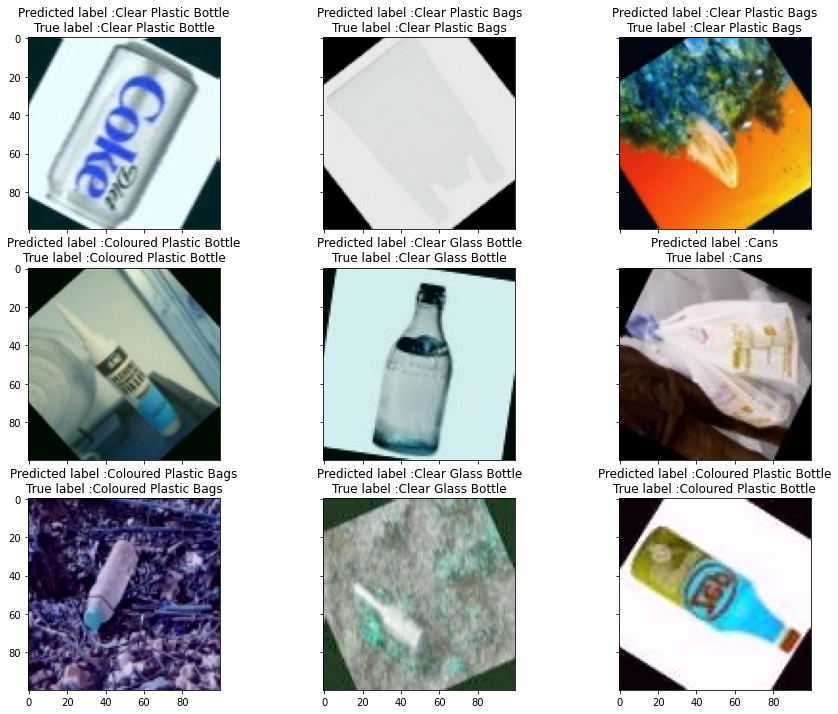

In [ ]:
label=['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

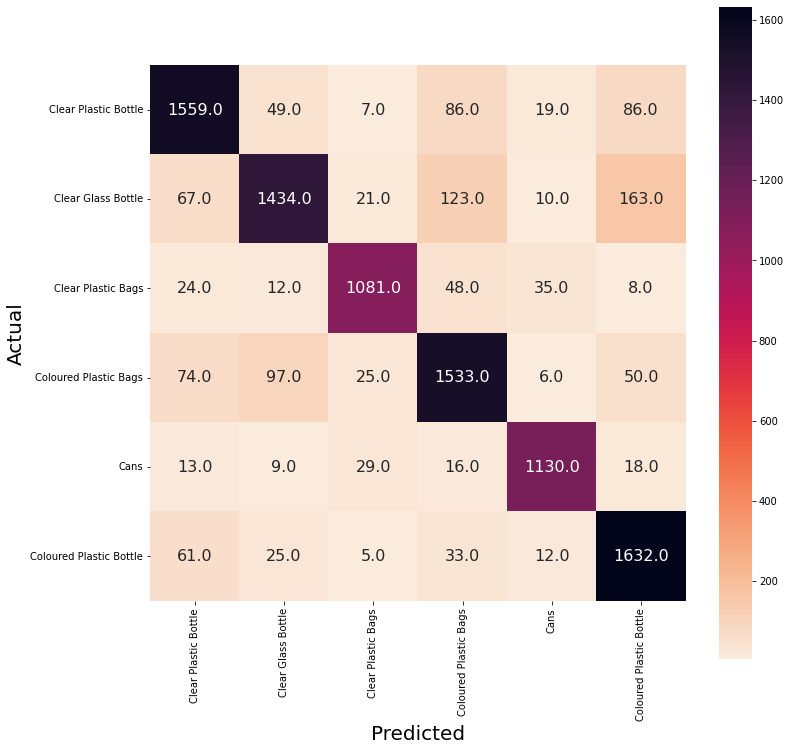

In [ ]:
# Confusion Matrix
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
# Statistical Analysis
from sklearn.metrics import classification_report, log_loss, accuracy_score

y_pred=model.predict(xtest)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(ytest,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1806
           1       0.88      0.79      0.83      1818
           2       0.93      0.89      0.91      1208
           3       0.83      0.86      0.85      1785
           4       0.93      0.93      0.93      1215
           5       0.83      0.92      0.88      1768

    accuracy                           0.87      9600
   macro avg       0.88      0.88      0.88      9600
weighted avg       0.87      0.87      0.87      9600



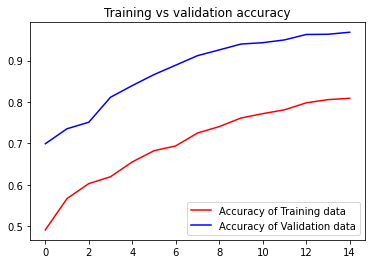

<Figure size 432x288 with 0 Axes>

In [ ]:
# Training and Validation accuracy
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

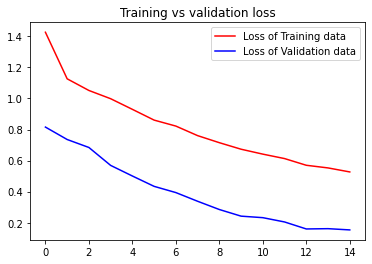

<Figure size 432x288 with 0 Axes>

In [ ]:
# Training and Validation loss
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()